# Flight Delays — ETL, KPIs, Advanced Visualizations & Models
The project centers on the 2015 Flight Delays and Cancellations file from Kaggle. It lists every scheduled passenger flight in the United States for the year 2015 along with the airline, flight number, departure and arrival airports, planned and actual times, minutes of delay, and whether the flight was cancelled or diverted.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

100%|███████████████████████████████████████████████████████████████████████████████| 191M/191M [01:36<00:00, 2.07MB/s]

Extracting files...


Path to dataset files: C:\Users\navttc.2025\.cache\kagglehub\datasets\usdot\flight-delays\versions\1


In [2]:
# 1. Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,5)


## 2. Load data
Set file paths below if your CSVs are located elsewhere.
The dataset downloaded and path is copied from local machine's folder

In [3]:
# 2. Load files (update paths if needed)

AIRLINES_CSV = r"C:\Users\navttc.2025\.cache\kagglehub\datasets\usdot\flight-delays\versions\1\airlines.csv"
AIRPORTS_CSV = r"C:\Users\navttc.2025\.cache\kagglehub\datasets\usdot\flight-delays\versions\1\airports.csv"
FLIGHTS_CSV = r"C:\Users\navttc.2025\.cache\kagglehub\datasets\usdot\flight-delays\versions\1\flights.csv"

airlines = pd.read_csv(AIRLINES_CSV)
airports = pd.read_csv(AIRPORTS_CSV)
flights = pd.read_csv(FLIGHTS_CSV)

print("Flights:", flights.shape)
print("Airlines:", airlines.shape)
print("Airports:", airports.shape)


Flights: (5819079, 31)
Airlines: (14, 2)
Airports: (322, 7)


### Quick sanity: show first few columns of the flights table
(Inspect to confirm column names match expected; if not, rename accordingly.)


In [4]:
display(flights.head())
print("\nColumns:")
print(flights.columns.tolist())

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN



Columns:
['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


## 3. Robust merges & type fixes
- Make sure airport/airline codes are strings (avoids int+str concat errors).
- Merge airline names and origin/destination airport metadata with distinct prefixes to avoid overwriting.


In [5]:
# Ensure code columns are string
for c in ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT']:
    if c in flights.columns:
        flights[c] = flights[c].astype(str)

# Prepare lookups without modifying originals
airlines_lu = airlines.rename(columns={'IATA_CODE':'AIRLINE_CODE','AIRLINE':'AIRLINE_NAME'}).copy()
airports_lu = airports.rename(columns={'IATA_CODE':'AP_CODE','AIRPORT':'AIRPORT_NAME'}).copy()

# Merge airline name (non-destructive)
if 'AIRLINE' in flights.columns:
    flights = flights.merge(airlines_lu[['AIRLINE_CODE','AIRLINE_NAME']],
                            left_on='AIRLINE', right_on='AIRLINE_CODE', how='left')

# Merge origin airport info with ORIG_ prefix
orig_map = airports_lu[['AP_CODE','AIRPORT_NAME','CITY','STATE','LATITUDE','LONGITUDE']].rename(columns={
    'AP_CODE':'ORIG_CODE','AIRPORT_NAME':'ORIG_AIRPORT_NAME','CITY':'ORIG_CITY','STATE':'ORIG_STATE',
    'LATITUDE':'ORIG_LAT','LONGITUDE':'ORIG_LON'
})
flights = flights.merge(orig_map, left_on='ORIGIN_AIRPORT', right_on='ORIG_CODE', how='left')

# Merge destination airport info with DEST_ prefix
dest_map = airports_lu[['AP_CODE','AIRPORT_NAME','CITY','STATE','LATITUDE','LONGITUDE']].rename(columns={
    'AP_CODE':'DEST_CODE','AIRPORT_NAME':'DEST_AIRPORT_NAME','CITY':'DEST_CITY','STATE':'DEST_STATE',
    'LATITUDE':'DEST_LAT','LONGITUDE':'DEST_LON'
})
flights = flights.merge(dest_map, left_on='DESTINATION_AIRPORT', right_on='DEST_CODE', how='left')

# Canonical airline name column
if 'AIRLINE_NAME' not in flights.columns:
    # if merging didn't create it, fallback to original code column as string
    flights['AIRLINE_NAME'] = flights.get('AIRLINE', '').astype(str)

print("After merges — sample columns:")
print([c for c in flights.columns if any(k in c for k in ['AIRLINE','ORIG_','DEST_'])][:40])


After merges — sample columns:
['AIRLINE', 'AIRLINE_DELAY', 'AIRLINE_CODE', 'AIRLINE_NAME', 'ORIG_CODE', 'ORIG_AIRPORT_NAME', 'ORIG_CITY', 'ORIG_STATE', 'ORIG_LAT', 'ORIG_LON', 'DEST_CODE', 'DEST_AIRPORT_NAME', 'DEST_CITY', 'DEST_STATE', 'DEST_LAT', 'DEST_LON']


## 4. Time preprocessing
Extract hour and minutes from HHMM fields (e.g., 2350 -> 23, 1430 -> 14), add cyclical encoding (sin/cos).
We keep originals in case you need them for debugging.


In [6]:
def extract_time_features(df, col):
    hr_col = col + "_HOUR"
    min_col = col + "_MIN"
    sin_col = col + "_SIN"
    cos_col = col + "_COS"
    df[hr_col] = np.nan
    df[min_col] = np.nan
    non_null = df[col].dropna()
    # safe convert to int where possible
    try:
        non_null_int = non_null.astype(int)
    except:
        non_null_int = pd.to_numeric(non_null, errors='coerce').dropna().astype(int)
    df.loc[non_null_int.index, hr_col] = (non_null_int // 100).astype(int)
    df.loc[non_null_int.index, min_col] = ((non_null_int // 100) * 60 + (non_null_int % 100)).astype(int)
    # cyclical (only where hour exists)
    hr_exists = df[hr_col].dropna()
    df.loc[hr_exists.index, sin_col] = np.sin(2 * np.pi * df.loc[hr_exists.index, hr_col] / 24)
    df.loc[hr_exists.index, cos_col] = np.cos(2 * np.pi * df.loc[hr_exists.index, hr_col] / 24)
    return df

for tcol in ['SCHEDULED_DEPARTURE','DEPARTURE_TIME','SCHEDULED_ARRIVAL','ARRIVAL_TIME']:
    if tcol in flights.columns:
        flights = extract_time_features(flights, tcol)

# Ensure hour columns numeric
for h in ['SCHEDULED_DEPARTURE_HOUR','DEPARTURE_TIME_HOUR','SCHEDULED_ARRIVAL_HOUR','ARRIVAL_TIME_HOUR']:
    if h in flights.columns:
        flights[h] = pd.to_numeric(flights[h], errors='coerce')


## 5. Outlier capping (1st/99th percentiles)
We create `_CAPPED` columns to preserve raw values and reduce effect of extreme outliers on means/plots.


In [7]:
def cap_outliers(df, col, low_q=0.01, high_q=0.99):
    if col not in df.columns:
        return
    low = df[col].quantile(low_q)
    high = df[col].quantile(high_q)
    df[col + "_CAPPED"] = df[col].clip(lower=low, upper=high)

cols_to_cap = ['DEPARTURE_DELAY','ARRIVAL_DELAY','DISTANCE','AIR_TIME','TAXI_OUT','TAXI_IN']
for c in cols_to_cap:
    cap_outliers(flights, c)
print("Capped columns created (if original columns existed).")


Capped columns created (if original columns existed).


## 6. Delay buckets, ROUTE, DATE, hour bins
- Delay buckets: On-time ≤5, Minor 6–30, Major >30
- ROUTE column: ORIGIN→DEST (string)
- DATE column from YEAR/MONTH/DAY for rolling metrics
- DEP_HOUR_BIN (Night/Morning/Afternoon/Evening)


In [8]:
# Delay bucket function
def dep_bucket(x):
    if pd.isna(x):
        return np.nan
    if x <= 5:
        return 'On-time'
    elif x <= 30:
        return 'Minor'
    else:
        return 'Major'

if 'DEPARTURE_DELAY' in flights.columns:
    flights['DEP_DELAY_BUCKET'] = flights['DEPARTURE_DELAY'].apply(dep_bucket)
if 'ARRIVAL_DELAY' in flights.columns:
    flights['ARR_DELAY_BUCKET'] = flights['ARRIVAL_DELAY'].apply(dep_bucket)

# ROUTE
if 'ORIGIN_AIRPORT' in flights.columns and 'DESTINATION_AIRPORT' in flights.columns:
    flights['ROUTE'] = flights['ORIGIN_AIRPORT'].astype(str) + "→" + flights['DESTINATION_AIRPORT'].astype(str)

# DATE (safe)
if {'YEAR','MONTH','DAY'}.issubset(set(flights.columns)):
    flights['DATE'] = pd.to_datetime(flights[['YEAR','MONTH','DAY']], errors='coerce')
else:
    flights['DATE'] = pd.to_datetime(flights.get('FL_DATE', pd.NaT), errors='coerce')

# Hour bins for scheduled departure (use SCHEDULED_DEPARTURE_HOUR if available)
hour_col = 'SCHEDULED_DEPARTURE_HOUR' if 'SCHEDULED_DEPARTURE_HOUR' in flights.columns else 'DEPARTURE_TIME_HOUR'
if hour_col in flights.columns:
    bins = [0,6,12,18,24]
    labels = ['Night','Morning','Afternoon','Evening']
    flights['DEP_HOUR_BIN'] = pd.cut(flights[hour_col].fillna(-1), bins=bins, labels=labels, right=False)


## 7. KPI builder helper
We will compute consistent KPIs (mean, median, 95th percentile, #flights, on-time%).
Use `build_kpi()` to produce tables for hour/airline/route.


In [9]:
# KPI builder
def percentile95(x):
    x = x.dropna()
    return np.percentile(x,95) if len(x)>0 else np.nan

def build_kpi(df, group_col, min_flights=0):
    group = df.groupby(group_col)
    res = group.agg(
        DEPARTURE_DELAY_mean = ('DEPARTURE_DELAY','mean'),
        DEPARTURE_DELAY_median = ('DEPARTURE_DELAY','median'),
        DEPARTURE_DELAY_p95 = ('DEPARTURE_DELAY', lambda x: percentile95(x)),
        ARRIVAL_DELAY_mean = ('ARRIVAL_DELAY','mean') if 'ARRIVAL_DELAY' in df.columns else ('DEPARTURE_DELAY','mean'),
        ARRIVAL_DELAY_median = ('ARRIVAL_DELAY','median') if 'ARRIVAL_DELAY' in df.columns else ('DEPARTURE_DELAY','median'),
        ARRIVAL_DELAY_p95 = ('ARRIVAL_DELAY', lambda x: percentile95(x)) if 'ARRIVAL_DELAY' in df.columns else ('DEPARTURE_DELAY', lambda x: percentile95(x)),
        NUM_FLIGHTS = ('ROUTE','count') if 'ROUTE' in df.columns else ('DEPARTURE_DELAY','count'),
        ON_TIME_PCT = ('DEP_DELAY_BUCKET', lambda x: (x=='On-time').mean()*100)
    ).reset_index()
    if min_flights > 0:
        res = res[res['NUM_FLIGHTS'] >= min_flights]
    return res

# KPIs
if hour_col in flights.columns:
    kpi_hour = build_kpi(flights, hour_col)
else:
    kpi_hour = pd.DataFrame()

kpi_airline = build_kpi(flights, 'AIRLINE_NAME') if 'AIRLINE_NAME' in flights.columns else build_kpi(flights, 'AIRLINE')
kpi_route = build_kpi(flights, 'ROUTE', min_flights=50) if 'ROUTE' in flights.columns else pd.DataFrame()

print("KPIs shapes — hour:", getattr(kpi_hour,'shape',None), "airline:", kpi_airline.shape, "route:", kpi_route.shape)


KPIs shapes — hour: (24, 9) airline: (14, 9) route: (7033, 9)


## 8. Basic EDA visualizations
- Average departure delay by hour
- Monthly average delay
- Top airlines & airports by delay


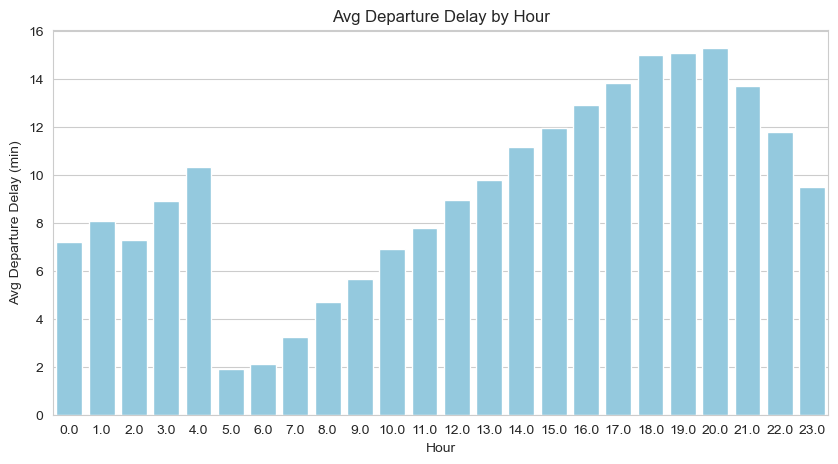

In [10]:
# Avg departure delay by hour
if not kpi_hour.empty:
    plt.figure(figsize=(10,5))
    sns.barplot(x=kpi_hour[hour_col], y=kpi_hour['DEPARTURE_DELAY_mean'], color='skyblue')
    plt.title("Avg Departure Delay by Hour")
    plt.xlabel("Hour")
    plt.ylabel("Avg Departure Delay (min)")
    plt.show()



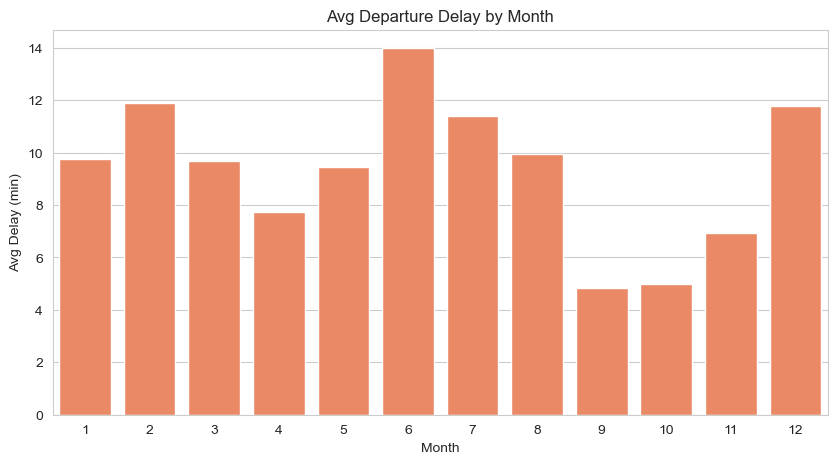

In [11]:
# Monthly average delay
if 'MONTH' in flights.columns:
    monthly_delay = flights.groupby('MONTH')['DEPARTURE_DELAY'].mean().sort_index()
    plt.figure(figsize=(10,5))
    sns.barplot(x=monthly_delay.index, y=monthly_delay.values, color='coral')
    plt.title("Avg Departure Delay by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg Delay (min)")
    plt.show()

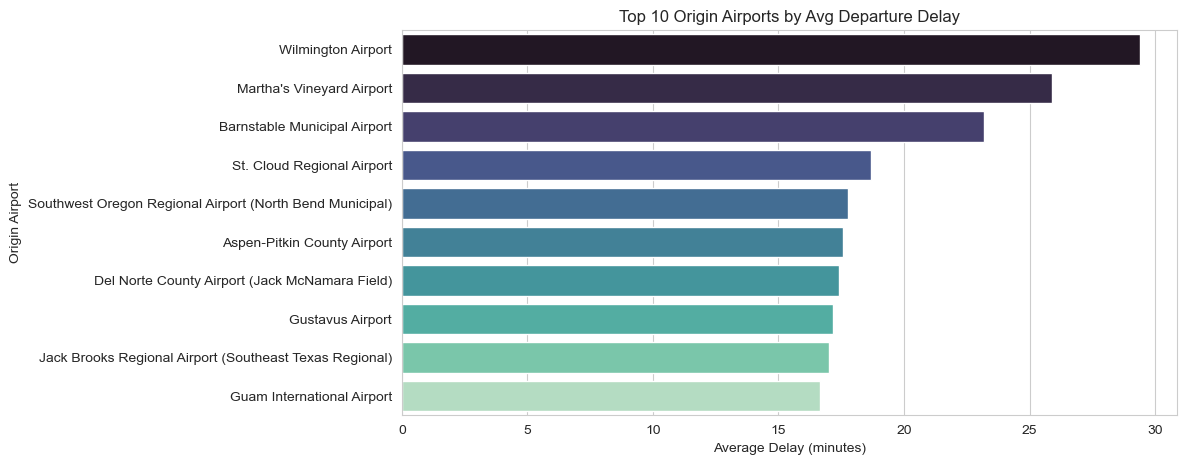

In [12]:
# Top 10 origin airports by avg delay
if 'ORIG_AIRPORT_NAME' in flights.columns:
    origin_delay = (
        flights.groupby('ORIG_AIRPORT_NAME')['DEPARTURE_DELAY']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10,5))
    sns.barplot(
        x=origin_delay.values,
        y=origin_delay.index,
        palette='mako'
    )
    plt.title("Top 10 Origin Airports by Avg Departure Delay")
    plt.xlabel("Average Delay (minutes)")
    plt.ylabel("Origin Airport")
    plt.show()

else:
    print("Column 'ORIG_AIRPORT_NAME' NOT found.")


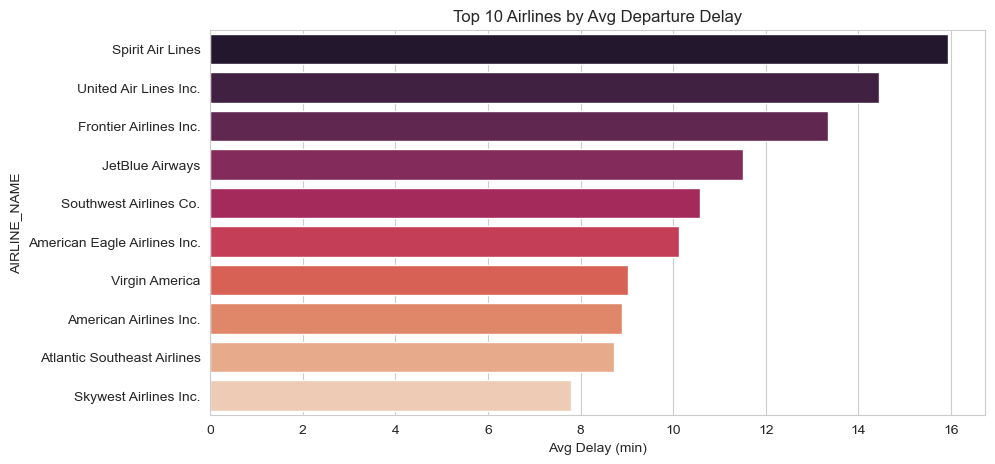

In [13]:
# Top 10 Airlines by avg delay
if 'AIRLINE_NAME' in flights.columns:
    top_airlines = kpi_airline.sort_values('DEPARTURE_DELAY_mean', ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x='DEPARTURE_DELAY_mean', y='AIRLINE_NAME', data=top_airlines, palette='rocket')
    plt.title("Top 10 Airlines by Avg Departure Delay")
    plt.xlabel("Avg Delay (min)")
    plt.show()

## 9. Advanced visualizations (heatmap, distribution, month×hour heatmap, route map, airport geo, airline dashboard)
These are robust and guarded.


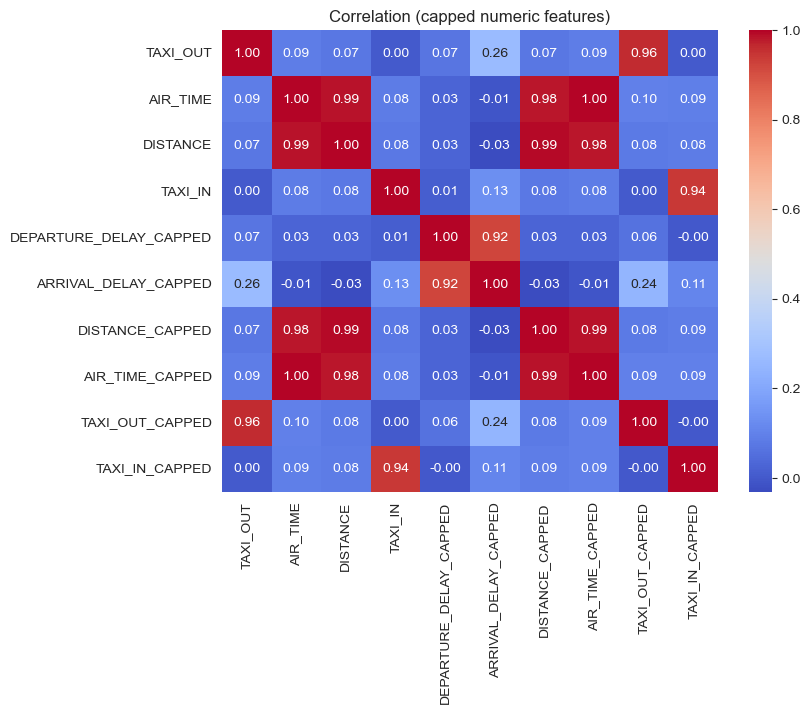

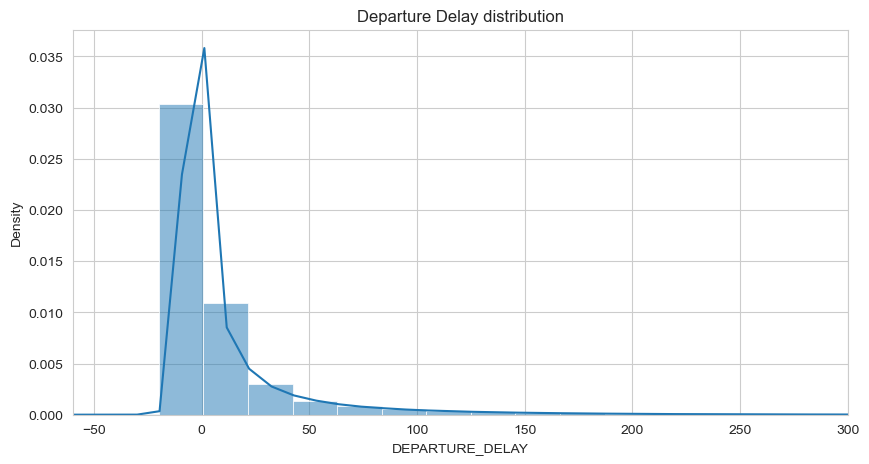

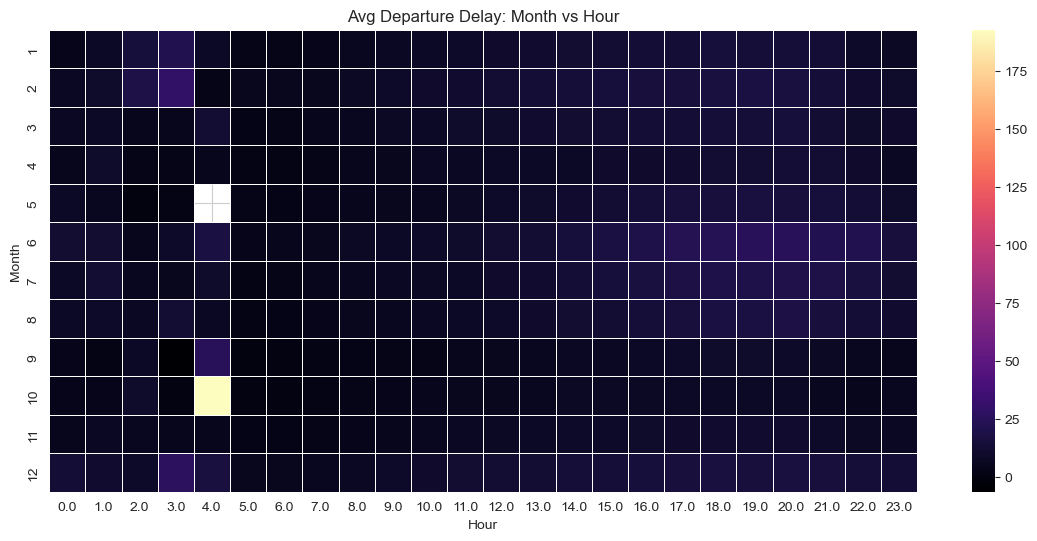

In [14]:
# 1) Correlation heatmap (capped numeric features)
num_cols = [c for c in flights.columns if any(x in c for x in ['DEPARTURE_DELAY_CAPPED','ARRIVAL_DELAY_CAPPED','DISTANCE','AIR_TIME','TAXI_OUT','TAXI_IN'])]
if num_cols:
    corr = flights[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation (capped numeric features)")
    plt.show()
else:
    print("No capped numeric columns for correlation.")

# 2) Delay distribution (hist + KDE)
if 'DEPARTURE_DELAY' in flights.columns:
    plt.figure(figsize=(10,5))
    sns.histplot(flights['DEPARTURE_DELAY'].dropna(), bins=100, kde=True, stat='density')
    plt.xlim(-60, 300)
    plt.title("Departure Delay distribution")
    plt.show()

# 3) Month vs Hour heatmap
if 'MONTH' in flights.columns and hour_col in flights.columns:
    heat = flights.pivot_table(index='MONTH', columns=hour_col, values='DEPARTURE_DELAY', aggfunc='mean')
    heat = heat.dropna(how='all').dropna(axis=1, how='all')
    plt.figure(figsize=(14,6))
    sns.heatmap(heat, cmap='magma', linewidths=.4)
    plt.title("Avg Departure Delay: Month vs Hour")
    plt.xlabel("Hour")
    plt.ylabel("Month")
    plt.show()


## 10. Modeling — predict delayed (>5m) vs on-time
- Build baseline Logistic Regression.
- Impute missing values (median), encode categorical features.
- Report confusion matrix, AUC, and show ROC curve.
- Also train a "severe delays >60m" model.


Feature columns used: ['SCHEDULED_DEPARTURE_HOUR', 'SCHEDULED_DEPARTURE_MIN', 'DEPARTURE_TIME_HOUR', 'DEPARTURE_TIME_MIN', 'DISTANCE', 'AIR_TIME', 'TAXI_OUT', 'TAXI_IN', 'SCHEDULED_DEPARTURE_SIN', 'SCHEDULED_DEPARTURE_COS', 'DEPARTURE_TIME_SIN', 'DEPARTURE_TIME_COS', 'SCHEDULED_ARRIVAL_SIN', 'SCHEDULED_ARRIVAL_COS', 'ARRIVAL_TIME_SIN', 'ARRIVAL_TIME_COS', 'AIRLINE_NAME_enc', 'ORIGIN_AIRPORT_enc', 'DESTINATION_AIRPORT_enc']
Confusion Matrix:
 [[1260540   16627]
 [ 342425  126132]]
AUC: 0.7932115685526258


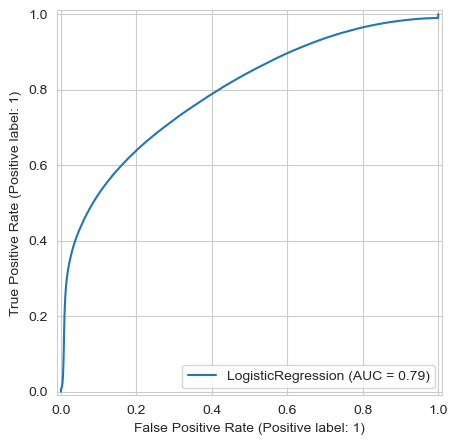

In [16]:
# Prepare targets
if 'DEPARTURE_DELAY' not in flights.columns:
    raise ValueError("DEPARTURE_DELAY missing — cannot build models.")
flights['TARGET'] = (flights['DEPARTURE_DELAY'] > 5).astype(int)
flights['SEVERE'] = (flights['DEPARTURE_DELAY'] > 60).astype(int)

# Build feature list (safe)
feat_cols = []
# add numeric basics if present
for c in ['SCHEDULED_DEPARTURE_HOUR','SCHEDULED_DEPARTURE_MIN','DEPARTURE_TIME_HOUR','DEPARTURE_TIME_MIN','DISTANCE','AIR_TIME','TAXI_OUT','TAXI_IN']:
    if c in flights.columns:
        feat_cols.append(c)
# cyclical features
feat_cols += [c for c in flights.columns if c.endswith('_SIN') or c.endswith('_COS')]
# encode small set of categorical columns
for c in ['AIRLINE_NAME','ORIGIN_AIRPORT','DESTINATION_AIRPORT']:
    if c in flights.columns:
        flights[c + '_enc'] = LabelEncoder().fit_transform(flights[c].astype(str).fillna('NA'))
        feat_cols.append(c + '_enc')

# ensure unique and existing
feat_cols = [c for c in pd.unique(feat_cols) if c in flights.columns]
print("Feature columns used:", feat_cols[:20])

X = flights[feat_cols].copy()
y = flights['TARGET'].copy()

# Impute numeric missing values (median)
imputer = SimpleImputer(strategy='median')
X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# train/test split with stratify
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=42, stratify=y.fillna(0))

# baseline logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# predictions + metrics
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print("Confusion Matrix:\n", cm)
print("AUC:", auc)

# ROC curve
try:
    RocCurveDisplay.from_estimator(clf, X_test, y_test)
    plt.show()
except Exception as e:
    print("ROC plot error:", e)


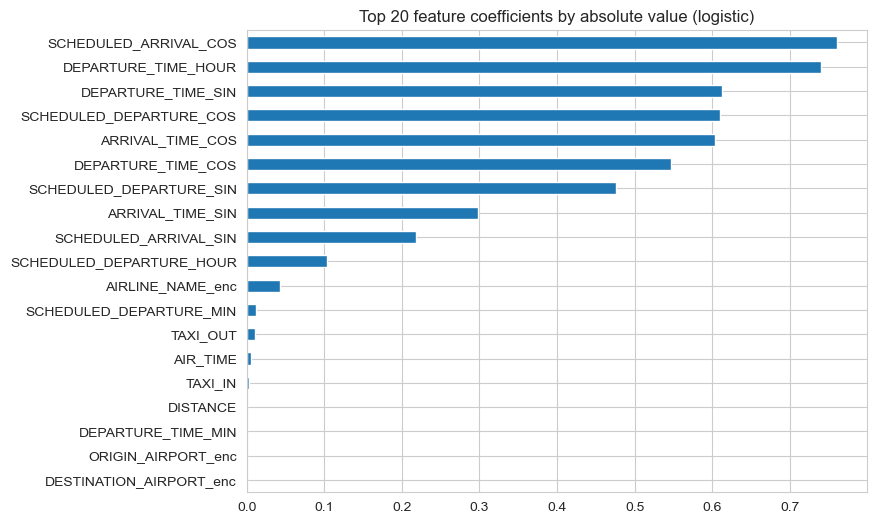

In [17]:
# Logistic feature coefficients (sorted by absolute value)
coefs = pd.Series(clf.coef_[0], index=X_train.columns).sort_values(key=abs, ascending=False)
plt.figure(figsize=(8,6))
coefs.head(20).abs().sort_values().plot(kind='barh')
plt.title("Top 20 feature coefficients by absolute value (logistic)")
plt.show()


In [18]:
# Severe delays model
y2 = flights['SEVERE']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_imp, y2, test_size=0.3, random_state=42, stratify=y2.fillna(0))
clf2 = LogisticRegression(max_iter=1000)
clf2.fit(X_train2, y_train2)
y2_prob = clf2.predict_proba(X_test2)[:,1]
print("Severe delay AUC:", roc_auc_score(y_test2, y2_prob))


Severe delay AUC: 0.8822148521856925


## 11. Rolling on-time % and export reports
- Daily on-time % and 7-day rolling average
- Export KPIs to Excel and a Plotly HTML page


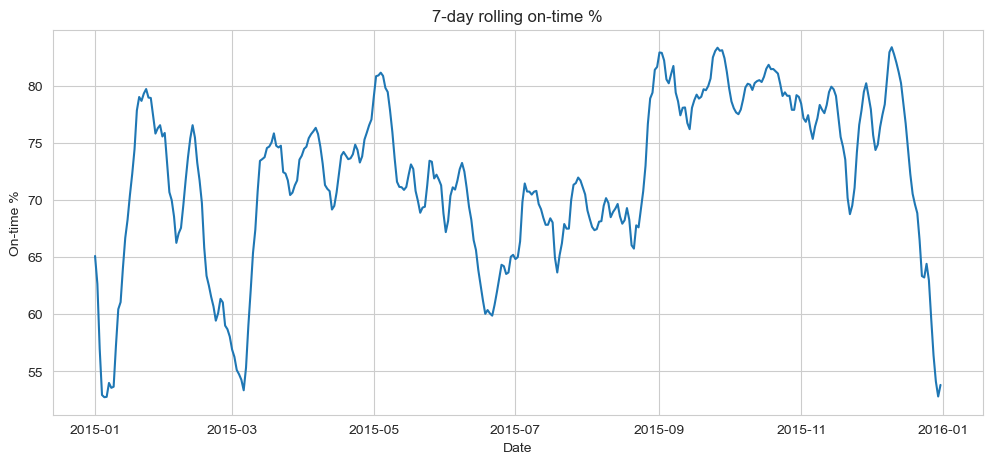

Exports created: mobility_summary.xlsx, mobility_reliability.html


In [19]:
# Daily on-time % and 7-day rolling
if 'DATE' in flights.columns:
    daily = flights.groupby('DATE')['DEP_DELAY_BUCKET'].apply(lambda x: (x=='On-time').mean()*100).reset_index().dropna()
    daily = daily.sort_values('DATE')
    daily['ROLL_7D'] = daily['DEP_DELAY_BUCKET'].rolling(7, min_periods=1).mean()

    plt.figure(figsize=(12,5))
    plt.plot(daily['DATE'], daily['ROLL_7D'])
    plt.title('7-day rolling on-time %')
    plt.ylabel('On-time %')
    plt.xlabel('Date')
    plt.show()
else:
    print("DATE column not found — skipping rolling metric.")

# Export KPIs to Excel
with pd.ExcelWriter("mobility_summary.xlsx") as writer:
    if not kpi_hour.empty:
        kpi_hour.to_excel(writer, sheet_name='ByHour', index=False)
    if not kpi_airline.empty:
        kpi_airline.to_excel(writer, sheet_name='ByAirline', index=False)
    if not kpi_route.empty:
        kpi_route.to_excel(writer, sheet_name='ByRoute', index=False)

# Export interactive HTML (avg departure delay by hour)
if not kpi_hour.empty:
    fig = px.line(kpi_hour, x=hour_col, y='DEPARTURE_DELAY_mean', title='Avg Departure Delay by Hour', markers=True)
    fig.write_html("mobility_reliability.html")
    print("Exports created: mobility_summary.xlsx, mobility_reliability.html")
else:
    print("kpi_hour empty — no HTML exported.")
